In [1]:
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import pyxirr
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
plt.style.use('seaborn-whitegrid')

class pct(float):
    def __str__(self):
        return '{:.4%}'.format(self)

In [2]:
# import formatted list of transaction
input_data = pd.read_csv('./test-portfolio.csv', sep=',', index_col='Date', parse_dates=True).sort_index()

In [3]:
input_data

,Ticker,Order,Price,Quantity,Fee
Date,,,,,
2019-10-01,LIQUIDITY,deposit,1.00,100000,0
2019-10-12,AAPL,purchase,61.50,350,35
2019-11-24,MSFT,purchase,148.30,250,25
2019-12-04,AAPL,sale,57.03,200,20
2020-01-06,FB,purchase,208.00,100,10
2020-01-25,LIQUIDITY,withdrawal,1.00,30000,0


In [4]:
# utilities
tickers = input_data.Ticker.unique()
tickers = tickers[tickers != 'LIQUIDITY']
tickers.sort()
start_date = input_data.index[0].date()
end_date = datetime.date(2020,1,29) 
timeline = pd.date_range(start=start_date, end=end_date)
years = timeline.shape[0]/365
day = datetime.timedelta(days=1)

In [5]:
# download actions and make them input_data
for ticker in tickers:
    spls = yf.Ticker(ticker).splits.loc[start_date + day : end_date + day]
    for date, split in spls.iteritems():
        input_data.loc[date] = [ticker, 'split', split, 0, 0]

In [6]:
market_values = yf.download(list(tickers), start=start_date + day, end=end_date + day)['Adj Close']
market_values = market_values.asfreq(freq='1D', method='ffill')

[*********************100%***********************]  3 of 3 completed


In [7]:
prices = pd.DataFrame(0, columns=tickers, index = timeline)
mkt_trans = pd.DataFrame(0, columns=tickers, index = timeline)
splits = pd.DataFrame(1, columns=tickers, index = timeline)
holdings = pd.DataFrame(0, columns=tickers, index = timeline)

In [8]:
account = pd.DataFrame(0, columns=['ext_mov', 'inv_cap', 'int_mov', 'holding'], index = timeline)

In [9]:
def deposit(date, trans):
    account.ext_mov.loc[date] = account.ext_mov.loc[date] + trans.Quantity * trans.Price
    account.int_mov.loc[date] = account.int_mov.loc[date] + trans.Quantity * trans.Price - trans.Fee

def withdrawal(date, trans):
    account.ext_mov.loc[date] = account.ext_mov.loc[date] - trans.Quantity * trans.Price
    account.int_mov.loc[date] = account.int_mov.loc[date] - trans.Quantity * trans.Price - trans.Fee
    
def reinvestment(date, trans):
    account.int_mov.loc[date] = account.int_mov.loc[date] + trans.Quantity * trans.Price - trans.Fee

def purchase(date, trans):
    account.int_mov.loc[date] = account.int_mov.loc[date] - trans.Quantity * trans.Price - trans.Fee
    mkt_trans.loc[date, trans.Ticker] = mkt_trans.loc[date, trans.Ticker] + trans.Quantity

def sell(date, trans):
    account.int_mov.loc[date] = account.int_mov.loc[date] + trans.Quantity * trans.Price - trans.Fee
    mkt_trans.loc[date, trans.Ticker] = mkt_trans.loc[date, trans.Ticker] - trans.Quantity

def dividend(date, trans):
    reinvestment(date, trans)

def split(date, trans):
    splits.loc[date] = trans.Price

In [10]:
def event(date, trans):
    if trans.Order == 'purchase':
        purchase(date, trans)
    elif trans.Order == 'sale':
        sell(date, trans)
    elif trans.Order == 'split':
        split(date, trans)
    else:
        pass

def event_cash(date, trans):
    if trans.Order == 'deposit':
        deposit(date, trans)
    elif trans.Order == 'withdrawal':
        withdrawal(date, trans)
    elif trans.Order == 'reinvestment':
        reinvestment(date, trans)
    elif trans.Order == 'dividend':
        dividend(date, trans)
    else:
        pass

In [11]:
def backfill(df, delta):
    for i in range(df.shape[0]):
        prev = 0
        if i > 0:
            prev = df.iloc[i-1]
        df.iloc[i] = prev + delta.iloc[i]

def forwprod(df):
    for i in reversed(range(df.shape[0])):
        nex = 1
        if i < df.shape[0]-2:
            nex = df.iloc[i+1]
        df.iloc[i] = nex * df.iloc[i]

In [12]:
for date, transaction in input_data.iterrows():
    event(date, transaction)
backfill(holdings, mkt_trans*splits)

In [13]:
# download actions and make them input_data
for ticker in tickers:
    divs = yf.Ticker(ticker).dividends.loc[start_date + day : end_date + day]
    for date, div in divs.iteritems():
        input_data.loc[date] = [ticker, 'dividend', div, holdings.loc[date, ticker], 0]

In [14]:
for date, transaction in input_data.iterrows():
    event_cash(date, transaction)

In [15]:
backfill(account.inv_cap, account.ext_mov)
backfill(account.holding, account.int_mov)

/opt/homebrew/Caskroom/miniforge/base/envs/fin/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [16]:
holdings_values = pd.DataFrame((holdings * market_values), columns=tickers, index=timeline)
holdings_values['LIQUIDITY'] = account.holding

In [17]:
portfolio = pd.DataFrame(0, columns=['Value'], index = timeline)
portfolio['Value'] = holdings_values.sum(axis=1)
portfolio['P/L'] = portfolio['Value'] - account.inv_cap
portfolio['%P/L'] = portfolio['P/L'] / account.inv_cap
portfolio['%day'] = portfolio['Value'].pct_change()
portfolio['Log Ret'] = np.log(portfolio['Value'] / portfolio['Value'].shift(1))

In [18]:
cash_flows = - account.ext_mov
cash_flows.iloc[-1] = portfolio['Value'].iloc[-1]

In [19]:
asset_allocation = holdings_values.copy()
asset_allocation = asset_allocation.divide(portfolio['Value'], axis=0)

XIRR: 25.5949% 
Annualised XIRR 98.8622%


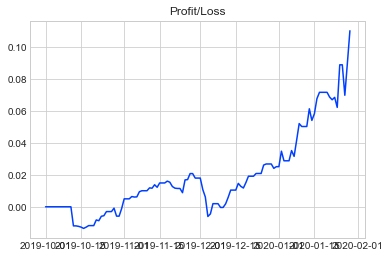

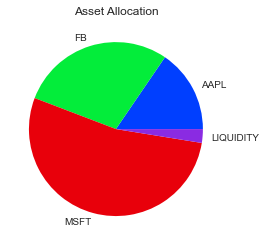

In [20]:
xirr = pyxirr.xirr(cash_flows.index, cash_flows.values)
ann_xirr = (1+xirr)**(365/portfolio.shape[0])-1
print('XIRR:', pct(xirr), '\nAnnualised XIRR', pct(ann_xirr))

plt.title('Profit/Loss')
plt.plot(portfolio['%P/L'])
plt.show()
plt.title('Asset Allocation')
plt.pie(asset_allocation.iloc[-1], labels=asset_allocation.columns)
plt.show()